In [34]:
import zipfile
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.io import wavfile
import struct
import webrtcvad

# Audio

## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

Библиотека librosa загружает и декорирует звук, как временной ряд.

y - представлен как одномерный массив numpy.

sr - содержит частоту дискретизации y, то есть количество отсчетов звука в секунду.

По умолчанию весь звук микшируется в моно и происходит Передискретизация до 22050 Гц во время загрузки.

Частота дискретизации (Sample Rate) - это количество аудио сэмпла, передаваемых в секунду, которое измеряется в Гц или кГц (число выборок аудиосигнала, приходящихся на секунду).
https://habr.com/ru/articles/668518/ 

In [35]:
# Раскрываем архив с аудиофайлам. Скачали его адресу https://files.sberdisk.ru/s/JRXlbcopIuvyFMZ
with zipfile.ZipFile('audio_yes_no.zip', 'r') as zip_ref:
    zip_ref.extractall('../datasets/')

<function matplotlib.pyplot.show(close=None, block=None)>

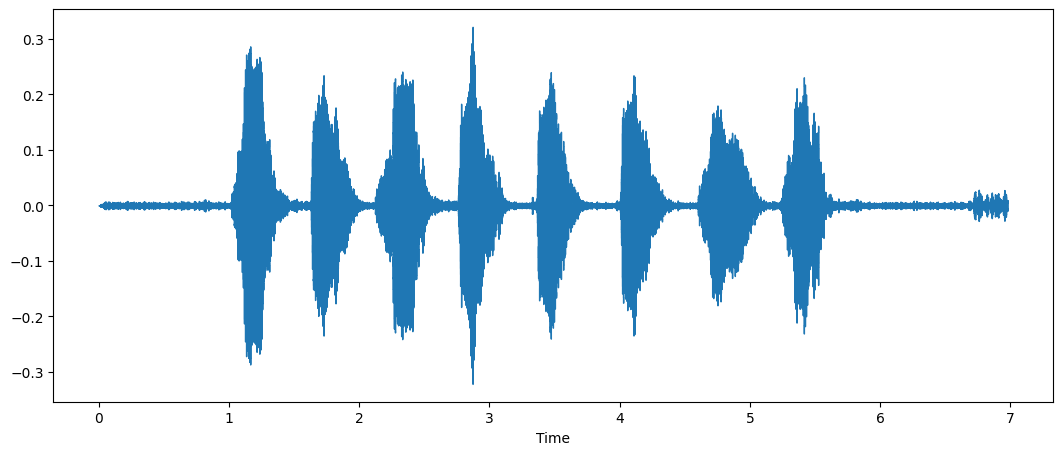

In [36]:
# визуализируем аудиоволнe из файла 0_1_0_1_1_1_0_0.wav с библиотекой librosa
filename = "datasets/audio_yes_no/waves_yesno 2/0_1_0_1_1_1_0_0.wav"
y, sr = librosa.load(filename)
plt.figure(figsize=(12.9,5.1))
librosa.display.waveshow(y, sr=sr, label='Time')
plt.show

In [37]:
ipd.Audio(filename)  # можно просулшать аудиофайл


## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) 
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

Спектрограмма
Спектрограмма - это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, присутствующих в форме волны. Обычно изображается в виде тепловой карты. .stft() преобразует данные в кратковременное преобразование Фурье. С помощью STFT можно определить амплитуду различных частот, воспроизводимых в данный момент времени аудиосигнала.

In [38]:
# Делаем преобразование Фурье, затем конвертируем спектрограмму в другую размерность - децибеллы
# y - это массив наших аудиозаписей
D = librosa.stft(y)
S = librosa.amplitude_to_db(np.abs(D), ref=np.max)

<function matplotlib.pyplot.show(close=None, block=None)>

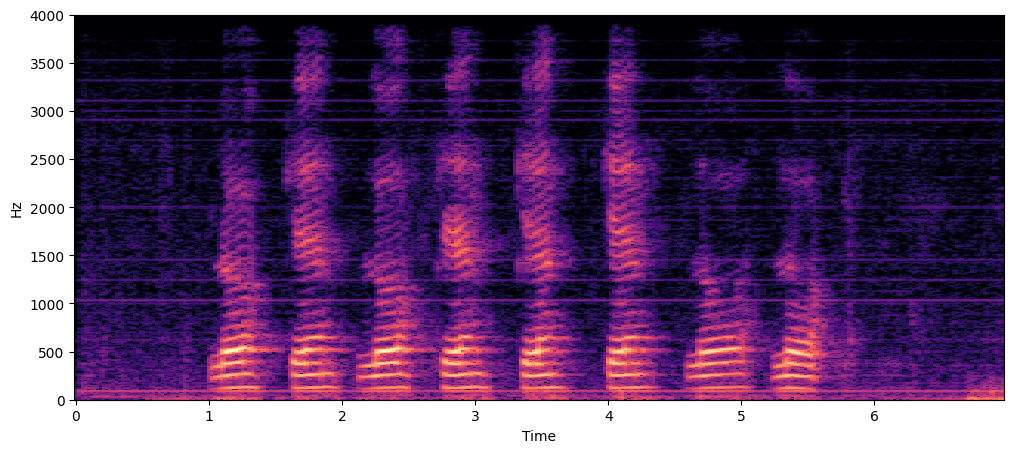

In [39]:
# Визуализируем спектрограмму с функцией librosa.display.specshow
plt.figure(figsize=(12, 5))
librosa.display.specshow(S, y_axis='hz', x_axis='time', sr=sr)
plt.ylim([0, 4000]) #огранимичает величину У до 4000 герц
plt.show

## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

In [97]:
def load_dataset(directory: str):
    sr = None
    X, labels, files = [], [], []
    for f in glob(directory + "/*.wav"):
        filename = os.path.basename(f)
        name = filename[:-4]
        y = [int(label) for label in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        files.append(filename)

    return X, labels, sr, files

In [98]:
X, labels, sr, files = load_dataset('datasets/audio_yes_no/waves_yesno 2')

In [99]:
# перевожу из массива в формат датафрейма
df = pd.DataFrame(data=X)
df_f = pd.DataFrame(data=files)

In [100]:
# фукнция train_test_split разделяет оба датасета на обучающий и тестовый
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df, df_f, 
                                                    test_size=0.2, random_state=42)
print("Количество файлов в тренировочном наборе: ", X_train.shape[0])
print("Количество файлов в тестовом наборе: ", X_test.shape[0])


Количество файлов в тренировочном наборе:  47
Количество файлов в тестовом наборе:  12


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи, 
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]] 
![sftp](../misc/images/vad.png)

Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

In [101]:
# https://www.kaggle.com/code/holzner/voice-activity-detection-example
# популярный VAD от Google, библиотека webrtcvad
vad = webrtcvad.Vad()
vad.set_mode(3)

In [102]:
# Возьмем один файл из архива для примера
train_audio_path = "datasets/audio_yes_no/waves_yesno 2"
filename = '0_0_0_1_0_1_1_0.wav'

In [103]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
# считывает файлы wav
sample_rate, samples = wavfile.read(os.path.join(train_audio_path, filename))

In [104]:
# конвертер образцов в 16-битные исходные потоки, с которыми работает библиотека webrtcvad
# dh - формат символов https://docs.python.org/3/library/struct.html 
# % - вставить значение после % в место %
raw_samples = struct.pack("%dh" % len(samples), *samples)

In [105]:
window_duration = 0.01 # поддерживает только 10 миллисекундные фреймы
# sample_rate = sr

samples_per_window = int(window_duration * sample_rate + 0.5) # у нас 80

bytes_per_sample = 2

In [106]:
# код получает список словариков с интервалами, размеченными функцией vad.is_speech - есть речь или нет
segments = []

for start in np.arange(0, len(samples), samples_per_window):
    stop = min(start + samples_per_window, len(samples))
    
    is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], 
                              sample_rate=sample_rate)

    segments.append(dict(
       start = start,
       stop = stop,
       is_speech = is_speech))

In [107]:
# segments
samples

array([ -1,   1,  -1, ..., -72,   7, -31], dtype=int16)

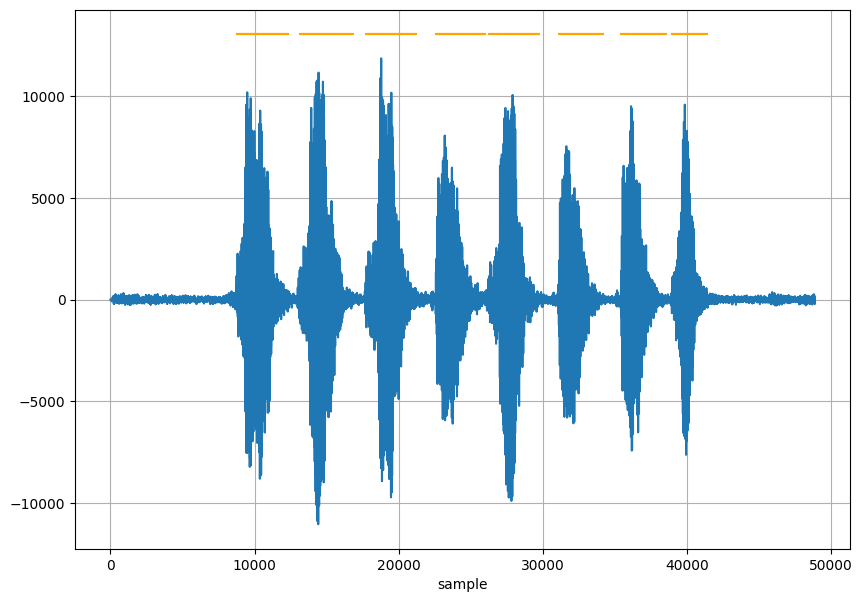

In [108]:
# визуализация аудиоволны и сегменты с голосом, всего 8 сегментов, при этом сегменты составлены из интервалов по 10 мс
plt.figure(figsize = (10,7))
plt.plot(samples)

ymax = max(samples)

# рисует сегменты с речью
for segment in segments:
    if segment['is_speech']:
        plt.plot([segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')

            


plt.xlabel('sample')
plt.grid()

In [109]:
# второй файл обработаем
filename = '0_1_0_1_1_1_0_0.wav'

sample_rate, samples = wavfile.read(os.path.join(train_audio_path, filename))

raw_samples = struct.pack("%dh" % len(samples), *samples)
window_duration = 0.01 # поддерживает только 10 миллисекундные фреймы
# sample_rate = sr

samples_per_window = int(window_duration * sample_rate + 0.5)

bytes_per_sample = 2
segments = []

for start in np.arange(0, len(samples), samples_per_window):
    stop = min(start + samples_per_window, len(samples))
    
    is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], 
                              sample_rate=sample_rate)

    segments.append(dict(
       start = start,
       stop = stop,
       is_speech = is_speech))

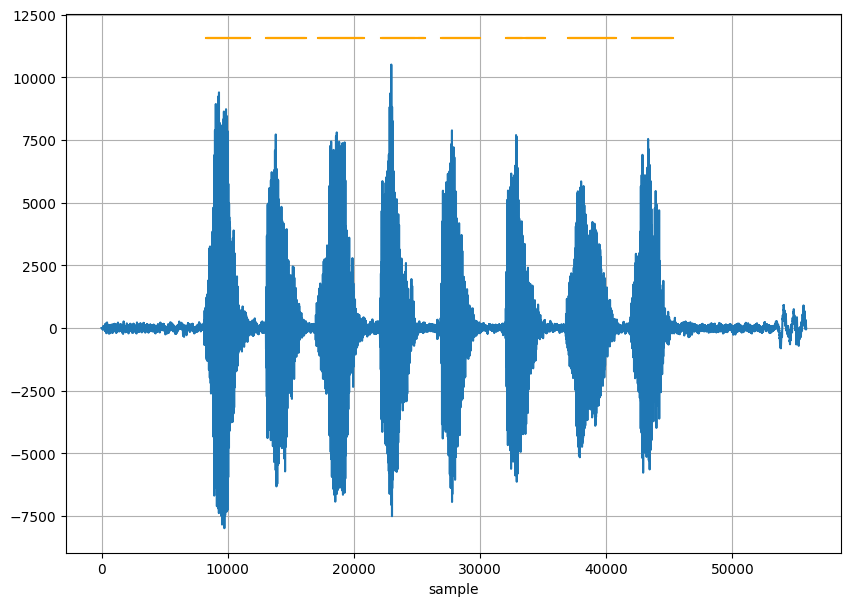

In [110]:
plt.figure(figsize = (10,7))
plt.plot(samples)

ymax = max(samples)

# рисует сегменты с речью
for segment in segments:
    if segment['is_speech']:
        plt.plot([segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')
       

plt.xlabel('sample')
plt.grid()

## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

In [318]:
train_audio_path = "datasets/audio_yes_no/waves_yesno 2"

In [319]:
# загружаем еще раз датасет
samples, labels, sr, files = load_dataset(train_audio_path)

In [376]:
# librosa.effects.split - функция возвращает массив интервалов с голосом
# использую эту функцию, потому что с webrtcvad.Vad() не получилось до конца разобраться
# top_db=10 - порог ниже, которого фукнция считает, что голосоа нет
# files - списко файлов из архива
# vad_segments - список всех сегментов с голосом по всем файлам
vad_segments = []
for filename in files:
    y, sr = librosa.load(os.path.join(train_audio_path, filename))
    intervals = librosa.effects.split(y, top_db=5, frame_length=1024, hop_length=400)
    # intervals = librosa.effects.split(y, top_db=10)
    vad_segments.append(intervals.tolist())

In [377]:
intervals

array([[ 23600,  26000],
       [ 36800,  40000],
       [ 52400,  54400],
       [ 65600,  68400],
       [ 80400,  83600],
       [ 94800,  97200],
       [110000, 112400],
       [123600, 126000]])

In [378]:
# intervals

In [379]:
len(vad_segments)

59

In [380]:
# функция из примера, на выходе возвращает набор аудиоданных, после преобразования Фурье, и набор меток "да", "нет" для обучения
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [381]:
X, y = make_dataset(samples, labels, vad_segments)

In [382]:
# y

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)
print("Количество файлов в тренировочном наборе: ", X_train.shape[0])
print("Количество файлов в тестовом наборе: ", X_test.shape[0])

Количество файлов в тренировочном наборе:  300
Количество файлов в тестовом наборе:  76


In [388]:
# обучение на модели логистической регрессии
from sklearn.linear_model import LogisticRegression

clf5 = LogisticRegression(solver='liblinear', fit_intercept=False, penalty='l1', random_state=21)

In [389]:
clf5.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, penalty='l1', random_state=21,
                   solver='liblinear')

In [390]:
a = clf5.score(X_test, y_test) * 100
print("Accuracy модели на тестовой выборке: ", a)

Accuracy модели на тестовой выборке:  96.05263157894737


In [391]:
# Посчитаем функцией accuracy_score
y_pred = clf5.predict(X_test)

In [392]:
from sklearn.metrics import accuracy_score 
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9605263157894737

In [393]:
# обучение модели опроных векторов
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)


SVC()

In [394]:
a = clf.score(X_test, y_test) * 100
print("Accuracy модели на тестовой выборке: ", a)

Accuracy модели на тестовой выборке:  97.36842105263158
